In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

## 데이터 로드

Read IBM stock OHLC ( open, high, low, close) and S&P 500 bid/ask df. df into pandas dfframe.

In [4]:
stock=pd.read_csv('삼성전자주가(20220406-20240405).csv')
df=stock.copy()

In [5]:
class Mymodel(nn.Module):
    def __init__(self, model):
        super(Mymodel, self).__init__()
        self.patch_tst = model
        self.fc=nn.Linear(model.config.num_input_channels, 1)
        # 가정: PatchTSTForPrediction의 출력 차원이 config.output_dim으로 주어짐

    def forward(self, x):
        # PatchTST 모델을 통과시킨 후의 출력
        x = self.patch_tst(past_values=x).prediction_outputs
        # 완전연결 계층을 통과시켜 최종 출력을 얻음
        x = self.fc(x)
        return x

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, 3, :])
        return out

In [133]:
class Stock:
    def __init__(self, df):
        super(Stock, self).__init__()
        self.df=df.copy()
        self.scaler_all = MinMaxScaler(feature_range=(0,1))
        self.scaler_target = MinMaxScaler(feature_range=(0,1))
        self.data=df.values
        self.predictions = []  # 예측값을 저장할 리스트
        self.actuals = []  # 실제값을 저장할 리스트
        self.train_losses = []
        self.val_losses = []

    def preprocessing(self):
        # index를 날짜로 설정
        self.df["Datetime"] = pd.to_datetime(self.df["Datetime"]).dt.strftime('%Y-%m-%d %H:%M:%S')
        self.df['Datetime'] = pd.to_datetime(self.df['Datetime'])
        self.df.set_index('Datetime', inplace=True)        
        self.df.drop('Adj Close', axis=1, inplace=True)
        return self.df

    def add_change(self, columns):
        for col in columns:
            self.df[f'{col}_chg']=self.df[col].pct_change()
        self.df.dropna(inplace=True)
        return self.df

    
    def add_col(self):
        self.df['change']=0
        self.df['target']=0
        for i in range(len(self.df)-1):
            self.df.iloc[i+1,5]=self.df.iloc[i+1,3]-self.df.iloc[i,3]
        self.df.loc[self.df['change']==0, 'target']=0
        self.df.loc[self.df['change']<0, 'target']=-1
        self.df.loc[self.df['change']>0, 'target']=1
        return self.df

    def scale_col(self, selected_feature):
        self.selected_feature=selected_feature
        data=self.df[selected_feature].values
        self.data = self.scaler_all.fit_transform(data)
        self.scaler_target.fit_transform(data[:,0].reshape(1,-1))
        self.scaler_target.min_, self.scaler_target.scale_ = self.scaler_all.min_[0], self.scaler_all.scale_[0]


    def create_sequences(self, data, seq_length):
        xs, ys = [], []
        for i in range(len(data)-seq_length):
            x = data[i:(i+seq_length), ]
            y = data[i+seq_length, 0]  # 예측하려는 값을 0에 배치
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    def data_loader(self, seq_len, type='train'):
        self.seq_len=seq_len
        train_size = int(len(self.data) * 0.7)
        val_size = int(len(self.data) * 0.2)
        test_size = len(self.data) - train_size - val_size

        if type=='train':
            X, y = self.create_sequences(self.data[:train_size], seq_len)
        elif type=='valid':
            X, y = self.create_sequences(self.data[train_size:train_size+val_size], seq_len)
        elif type=='test':
            X, y = self.create_sequences(self.data[train_size+val_size:], seq_len)
        else:
            X, y = self.create_sequences(self.data, seq_len)
                
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        data = TensorDataset(X, y)
        data_loader = DataLoader(dataset=data, batch_size=16, shuffle=False)

        return data_loader
    
    def create_model(self, input_size=6, hidden_size = 256, output_size = 1):
        # 모델 생성
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.model = LSTMModel(self.input_size, self.hidden_size, self.output_size)
    
    def train(self, train_loader, val_loader, test_loader, type, num_epoch = 100, min_delta=0.00001):
        
        optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        # 손실 함수 설정
        criterion = nn.MSELoss()

        # 학습 파라미터 설정
        self.num_epochs = num_epoch
        self.train_losses = []
        self.val_losses = []
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        min_delta = 0.00001  # 개선으로 간주되기 위한 최소 변화량
        best_loss = np.inf  # 가장 낮은 검증 손실을 추적dd
        last_val_loss = np.inf
    
        # 모델 학습
        if type == 'train':
            for epoch in range(self.num_epochs):
                self.model.train()  # 학습 모드로 설정
                train_loss = 0.0
                
                for inputs, labels in train_loader:
                    # 입력 데이터와 레이블을 GPU로 이동
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    # 기울기 초기화
                    optimizer.zero_grad()
                    
                    # 순방향 전파
                    outputs = self.model(inputs)
                    
                    # 손실 계산
                    loss = criterion(outputs.squeeze(), labels)
                    
                    # 역전파 및 가중치 업데이트
                    loss.backward()
                    optimizer.step()
                    
                    # 손실 누적
                    train_loss += loss.item() * inputs.size(0)
            
                train_loss /= len(train_loader.dataset)
                self.train_losses.append(train_loss)

                self.model.eval()  # 모델을 평가 모드로 설정
                val_loss = 0.0

                with torch.no_grad():
                    self.model.eval()
                    for inputs, labels in val_loader:
                        outputs = self.model(inputs)
                        loss = criterion(outputs.squeeze(), labels)
                        val_loss += loss.item() * inputs.size(0)  # 누적 손실 계산
                    # 에포크별 평균 검증 손실 계산
                    val_loss /= len(val_loader.dataset)
                    self.val_losses.append(val_loss)

                print(f'Epoch {epoch+1}/{self.num_epochs}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}')
                patience = 0
                if val_loss > best_loss + min_delta:
                    patience += 1
                    if patience == 25:
                        print("Early stopping initiated.")
                        print(f"Best Validation Loss: {best_loss:.5f}")
                        break
                else:
                    best_loss = val_loss
                    patience = 0
                    

                last_val_loss = val_loss  # 마지막 검증 손실 업데이트


            # 테스트 데이터셋으로 평가
            test_loss = 0.0
            with torch.no_grad():
                for inputs, targets in test_loader:
                    outputs = self.model(inputs)
                    test_loss += criterion(outputs, targets.unsqueeze(1)).item()

            print(f'Test Loss (MSE): {test_loss/len(test_loader):.4f}')
        
        if type == 'test':
            self.predictions=[]
            self.actuals=[]
            self.model.eval()  # 모델을 평가 모드로 설정
            test_losses = []  # 테스트 손실을 저장할 리스트

            with torch.no_grad():  # 기울기 계산을 비활성화
                for seqs, labels in test_loader:

                    outputs = self.model(seqs)

                    # 손실 계산
                    loss = criterion(outputs, labels)
                    test_losses.append(loss.item())

                    # 예측값과 실제값 저장
                    self.predictions.extend(outputs.view(-1).detach().numpy())
                    self.actuals.extend(labels.view(-1).detach().numpy())

            # 평균 테스트 손실 계산 및 출력
            average_test_loss = sum(test_losses) / len(test_losses)
            print(f'Average Test Loss: {average_test_loss}')
        
    def pred_value(self):
        self.predictions_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.predictions).reshape(-1,1)), -2)
        self.actuals_inverse = np.round(self.scaler_target.inverse_transform(np.array(self.actuals).reshape(-1,1)), -2)
        return self.predictions_inverse, self.actuals_inverse
    
    def diff(self):
        differences = [abs(pred - actual) for pred, actual in zip(self.predictions_inverse, self.actuals_inverse)]
        print("최대 : " , max(differences) ,"최소 : " , min(differences) ,"평균: " , sum(differences) / len(differences))

    def loss(self):
        # 훈련 손실과 검증 손실을 에포크별로 그래프로 그리기
        plt.figure(figsize=(10, 6))  # 그래프 크기 설정
        plt.plot(self.train_losses, label='Training Loss', marker='o')  # 훈련 손실 그래프
        plt.plot(self.val_losses, label='Validation Loss', marker='x')  # 검증 손실 그래프
        plt.title('Training and Validation Loss')  # 그래프 제목
        plt.xlabel('Epochs')  # x축 라벨
        plt.ylabel('Loss')  # y축 라벨
        plt.legend()  # 범례 표시
        plt.grid(True)  # 그리드 표시
        plt.show()  # 그래프 보여주기
    
    
    def show(self, type):
        if type=='chg':
            predictions_inverse=self.predictions_inverse[1:]
            actuals_inverse=self.actuals_inverse[1:]

        else:
            predictions_inverse=self.predictions_inverse
            actuals_inverse=self.actuals_inverse

        n = 60
        num_plots = len(predictions_inverse) // n
        if len(predictions_inverse) % n != 0:
            num_plots += 1

        # Plot 생성
        fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6*num_plots))

        for i in range(num_plots):
            start_index = i * n
            end_index = min((i + 1) * n, len(predictions_inverse))
            
            # Subplot 생성
            ax = axes[i] if num_plots > 1 else axes
            
            # 예측값과 실제값 그리기
            ax.plot(predictions_inverse[start_index:end_index], label='Predictions')
            ax.plot(actuals_inverse[start_index:end_index], label='Actuals')
            ax.set_title(f'Predictions vs Actuals (Subset {i+1})')
            ax.set_xlabel('Index')
            ax.set_ylabel('Values')
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()

In [134]:
stock=Stock(df)

In [135]:
stock.preprocessing()

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,0
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,1846582
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,901392
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,2053045
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,924688
...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,3548675
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,1732644
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,1052082


In [136]:
stock.df

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,0
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,1846582
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,901392
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,2053045
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,924688
...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,3548675
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,1732644
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,1052082


In [137]:
stock.add_col()

,Open,High,Low,Close,Volume,change,target
Datetime,,,,,,,
2022-04-06 09:00:00,68600.0,68800.0,68600.0,68700.0,0,0,0
2022-04-06 10:00:00,68600.0,68800.0,68600.0,68700.0,1846582,0,0
2022-04-06 11:00:00,68700.0,68700.0,68600.0,68600.0,901392,-100,-1
2022-04-06 12:00:00,68700.0,68700.0,68500.0,68600.0,2053045,0,0
2022-04-06 13:00:00,68600.0,68600.0,68500.0,68600.0,924688,0,0
...,...,...,...,...,...,...,...
2024-04-05 10:00:00,84700.0,84800.0,83800.0,84000.0,3548675,-700,-1
2024-04-05 11:00:00,83900.0,84300.0,83900.0,84200.0,1732644,200,1
2024-04-05 12:00:00,84300.0,84500.0,84100.0,84400.0,1052082,200,1


In [138]:
stock.scale_col(stock.df.columns[[0,1,2,5,4,3]]) # 종가
# stock.scale_col(stock.df.columns[[8,5,6,7,9]]) # 종가(변화율)

In [139]:
train_loader=stock.data_loader(4, 'train')

In [140]:
valid_loader=stock.data_loader(4, 'valid')

In [141]:
test_loader=stock.data_loader(4, 'test')

In [142]:
stock.create_model()

In [143]:
stock.train(train_loader, valid_loader, test_loader, 'train')

Epoch 1/100, Train Loss: 0.02298, Val Loss: 0.00309
Epoch 2/100, Train Loss: 0.00790, Val Loss: 0.00259
Epoch 3/100, Train Loss: 0.00669, Val Loss: 0.00232
Epoch 4/100, Train Loss: 0.00546, Val Loss: 0.00168
Epoch 5/100, Train Loss: 0.00419, Val Loss: 0.00114
Epoch 6/100, Train Loss: 0.00325, Val Loss: 0.00075
Epoch 7/100, Train Loss: 0.00244, Val Loss: 0.00053
Epoch 8/100, Train Loss: 0.00187, Val Loss: 0.00049
Epoch 9/100, Train Loss: 0.00141, Val Loss: 0.00055
Epoch 10/100, Train Loss: 0.00111, Val Loss: 0.00045
Epoch 11/100, Train Loss: 0.00087, Val Loss: 0.00057
Epoch 12/100, Train Loss: 0.00066, Val Loss: 0.00030
Epoch 13/100, Train Loss: 0.00054, Val Loss: 0.00027
Epoch 14/100, Train Loss: 0.00047, Val Loss: 0.00026
Epoch 15/100, Train Loss: 0.00044, Val Loss: 0.00022
Epoch 16/100, Train Loss: 0.00039, Val Loss: 0.00021
Epoch 17/100, Train Loss: 0.00040, Val Loss: 0.00017
Epoch 18/100, Train Loss: 0.00039, Val Loss: 0.00018
Epoch 19/100, Train Loss: 0.00037, Val Loss: 0.00017
Ep

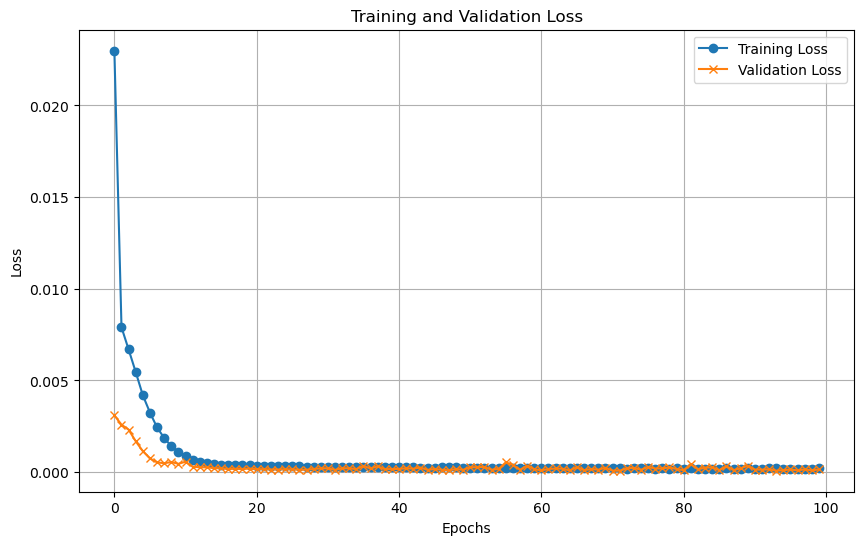

In [144]:
stock.loss()

In [146]:
stock.train(train_loader, valid_loader, test_loader, 'test')

Average Test Loss: 0.0014553339072000725


c:\Users\woora\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\woora\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [147]:
pred, act=stock.pred_value()

In [148]:
stock.diff()

최대 :  [2600.] 최소 :  [100.] 평균:  [526.71234]


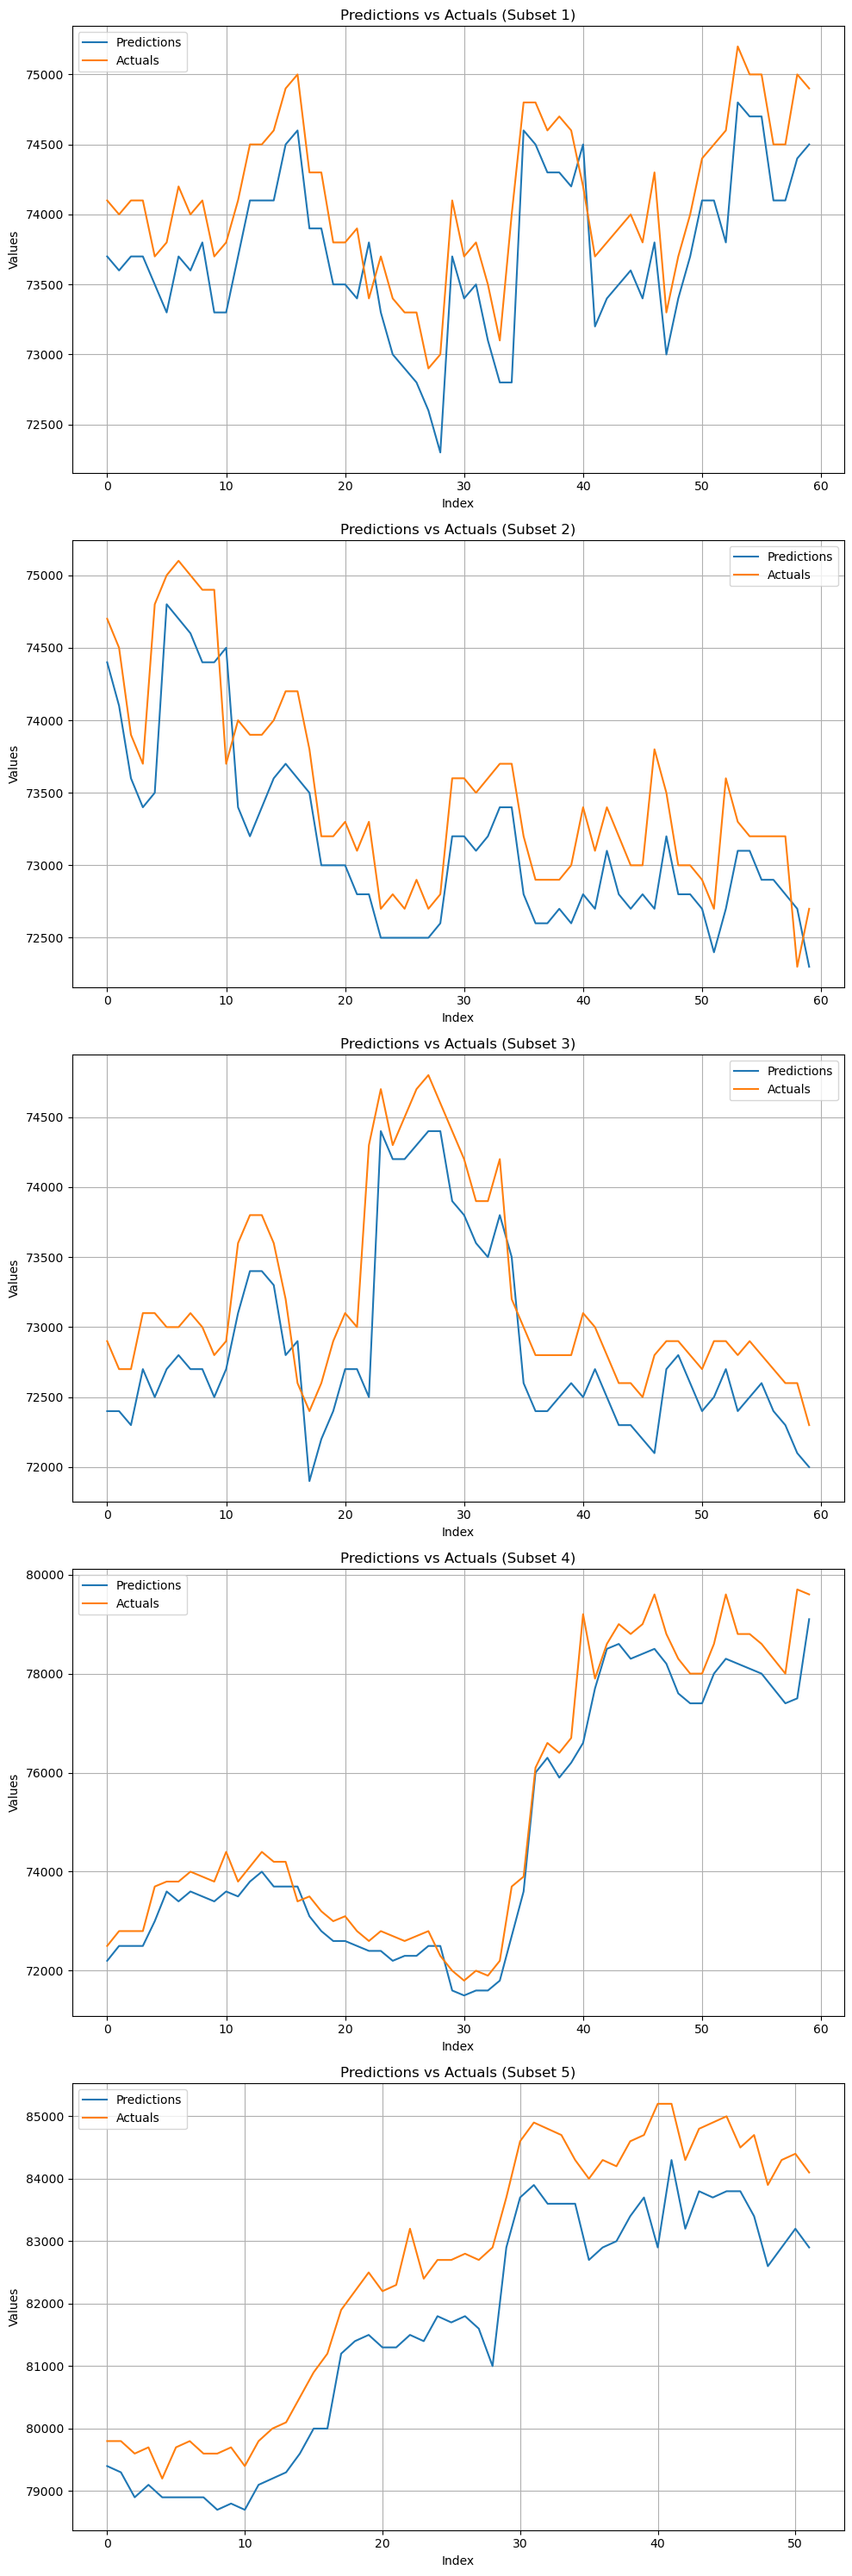

In [149]:
stock.show('origin')